<a href="https://colab.research.google.com/github/gnitnaw/LDL/blob/main/stand_alone/aFe2_2level_learning_mnist_minibatch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""
The MIT License (MIT)
Copyright (c) 2021 NVIDIA
Permission is hereby granted, free of charge, to any person obtaining a copy of
this software and associated documentation files (the "Software"), to deal in
the Software without restriction, including without limitation the rights to
use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
the Software, and to permit persons to whom the Software is furnished to do so,
subject to the following conditions:
The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
"""


'\nThe MIT License (MIT)\nCopyright (c) 2021 NVIDIA\nPermission is hereby granted, free of charge, to any person obtaining a copy of\nthis software and associated documentation files (the "Software"), to deal in\nthe Software without restriction, including without limitation the rights to\nuse, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of\nthe Software, and to permit persons to whom the Software is furnished to do so,\nsubject to the following conditions:\nThe above copyright notice and this permission notice shall be included in all\ncopies or substantial portions of the Software.\nTHE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR\nIMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS\nFOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR\nCOPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER\nIN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OU

This code example demonstrates how to extend aFe1_2level_learning_mnist_matmul to use mini-batches instead of individual training examples. More context for this code example can be found in the section "Mini-Batch Implementation" in Appendix F in the book Learning Deep Learning by Magnus Ekman (ISBN: 9780137470358).

The initial code is unchanged, apart from creating a list index_list that is used to index mini-batches.


In [2]:
! pip3 install idx2numpy
from google.colab import drive
drive.mount('/content/drive')
path_head = '/content/drive/MyDrive/Colab Notebooks/' # You have to change this. 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for idx2numpy: filename=idx2numpy-1.2.3-py3-none-any.whl size=7917 sha256=b25aea1af5386cd4b5df82caddf4876b1bf604d3ec8e86142b8e5c8d0074cf9c
  Stored in directory: /root/.cache/pip/wheels/1a/ce/ad/d5e95a35cfe34149aade5e500f2edd535c0566d79e9a8e1d8a
Successfully built idx2numpy
Mounted at /content/drive


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import idx2numpy

np.random.seed(7) # To make repeatable
LEARNING_RATE = 0.1
EPOCHS = 20
TRAIN_IMAGE_FILENAME = path_head+'data/mnist/train-images.idx3-ubyte'
TRAIN_LABEL_FILENAME = path_head+'data/mnist/train-labels.idx1-ubyte'
TEST_IMAGE_FILENAME = path_head+'data/mnist/t10k-images.idx3-ubyte'
TEST_LABEL_FILENAME = path_head+'data/mnist/t10k-labels.idx1-ubyte'
BATCH_SIZE = 32

# Function to read dataset.
def read_mnist():
    train_images = idx2numpy.convert_from_file(
        TRAIN_IMAGE_FILENAME)
    train_labels = idx2numpy.convert_from_file(
        TRAIN_LABEL_FILENAME)
    test_images = idx2numpy.convert_from_file(
        TEST_IMAGE_FILENAME)
    test_labels = idx2numpy.convert_from_file(
        TEST_LABEL_FILENAME)

    # Reformat and standardize.
    x_train = train_images.reshape(60000, 784)
    mean = np.mean(x_train)
    stddev = np.std(x_train)
    x_train = (x_train - mean) / stddev
    x_test = test_images.reshape(10000, 784)
    x_test = (x_test - mean) / stddev

    # One-hot encoded output.
    y_train = np.zeros((60000, 10))
    y_test = np.zeros((10000, 10))
    for i, y in enumerate(train_labels):
        y_train[i][y] = 1
    for i, y in enumerate(test_labels):
        y_test[i][y] = 1
    return x_train, y_train, x_test, y_test

# Read train and test examples.
x_train, y_train, x_test, y_test = read_mnist()
index_list = list(range(int(len(x_train)/BATCH_SIZE)))


The code representing the neurons and connections is shown below. The variables that were previously vector variables have now become matrices where the new dimension is the mini-batch size. The programming example assumes that the variable BATCH_SIZE has been initialized with the value 32.


In [4]:
def layer_w(neuron_count, input_count):
    weights = np.zeros((neuron_count, input_count+1))
    for i in range(neuron_count):
        for j in range(1, (input_count+1)):
            weights[i][j] = np.random.uniform(-0.1, 0.1)
    return weights

# Declare matrices and vectors representing the neurons.
hidden_layer_w = layer_w(25, 784)
hidden_layer_y = np.zeros((25, BATCH_SIZE))
hidden_layer_error = np.zeros((25, BATCH_SIZE))

output_layer_w = layer_w(10, 25)
output_layer_y = np.zeros((10, BATCH_SIZE))
output_layer_error = np.zeros((10, BATCH_SIZE))


The code that plots the learning progress is unchanged.


In [5]:
chart_x = []
chart_y_train = []
chart_y_test = []
def show_learning(epoch_no, train_acc, test_acc):
    global chart_x
    global chart_y_train
    global chart_y_test
    print('epoch no:', epoch_no, ', train_acc: ',
          '%6.4f' % train_acc,
          ', test_acc: ', '%6.4f' % test_acc)
    chart_x.append(epoch_no + 1)
    chart_y_train.append(1.0 - train_acc)
    chart_y_test.append(1.0 - test_acc)

def plot_learning():
    plt.plot(chart_x, chart_y_train, 'r-',
             label='training error')
    plt.plot(chart_x, chart_y_test, 'b-',
             label='test error')
    plt.axis([0, len(chart_x), 0.0, 1.0])
    plt.xlabel('training epochs')
    plt.ylabel('error')
    plt.legend()
    plt.show()


The code snippet below shows the functions for the forward pass, backward pass, and weight adjustment. The forward_pass function is straightforward. The only difference is that when creating the input to the output layer, we now need to extend it with a vector of bias terms instead of just a single bias term. It is a vector because there needs to be one bias element for each example in the minibatch. Another difference is that x is now a matrix representing a batch of training examples instead of a vector representing a single example. The code itself has not changed, but it is worth noting that the arguments to matmul are now two matrices instead of a matrix and a vector.

The backward_pass function is unchanged, although the input y_truth now is a matrix. The same applies to the global variables hidden_layer_error and output_layer_error that are used in the function.

In adjust_weights, we need to append a vector of bias terms (technically, a matrix where one dimension is 1) to the outputs from the hidden layer where the vector length represents the mini-batch size. We have added a for loop that loops through all the examples in the mini-batch, accumulates the deltas in the delta_matrix, and then divides by the mini-batch size. This is how we compute the average of the gradient. We then simply do the weight update just as in the previous implementation but now using this averaged matrix instead.


In [6]:
def forward_pass(x):
    global hidden_layer_y
    global output_layer_y
    # Activation function for hidden layer.
    hidden_layer_z = np.matmul(hidden_layer_w, x)
    hidden_layer_y = np.tanh(hidden_layer_z)
    hidden_output_array = np.concatenate(
        (np.ones((1, BATCH_SIZE)), hidden_layer_y))
    # Activation function for output layer.
    output_layer_z = np.matmul(output_layer_w,
        hidden_output_array)
    output_layer_y = 1.0 / (1.0 + np.exp(-output_layer_z))

def backward_pass(y_truth):
    global hidden_layer_error
    global output_layer_error
    # Backpropagate error for each output neuron.
    error_prime = -(y_truth - output_layer_y)
    output_log_prime = output_layer_y * (
        1.0 - output_layer_y)
    output_layer_error = error_prime * output_log_prime
    # Backpropagate error for each hidden neuron.
    hidden_tanh_prime = 1.0 - hidden_layer_y**2
    hidden_weighted_error = np.matmul(np.matrix.transpose(
        output_layer_w[:, 1:]), output_layer_error)
    hidden_layer_error = (
        hidden_tanh_prime * hidden_weighted_error)

def adjust_weights(x):
    global output_layer_w
    global hidden_layer_w
    delta_matrix = np.zeros((len(hidden_layer_error[:, 0]),
                             len(x[:, 0])))
    for i in range(BATCH_SIZE):
        delta_matrix += np.outer(hidden_layer_error[:, i],
                                 x[:, i]) * LEARNING_RATE
    delta_matrix /= BATCH_SIZE
    hidden_layer_w -= delta_matrix
    hidden_output_array = np.concatenate(
        (np.ones((1, BATCH_SIZE)), hidden_layer_y))
    delta_matrix = np.zeros(
        (len(output_layer_error[:, 0]),
         len(hidden_output_array[:, 0])))
    for i in range(BATCH_SIZE):
        delta_matrix += np.outer(
            output_layer_error[:, i],
            hidden_output_array[:, i]) * LEARNING_RATE
    delta_matrix /= BATCH_SIZE
    output_layer_w -= delta_matrix


The final code snippet shows the training loop for the mini-batch implementation. The for loops that loop over the training and test examples are now changed to handle one mini-batch per iteration. This includes logic to collect a number of training examples into a matrix that is then passed to the forward and backward pass functions.

We cheated a little bit in the outer loops (index j) by not properly handling the end of the training and test sets if they are not evenly divisible by the mini-batch size. Instead of worrying about how to use partially filled matrices, we simply skip the final few training and test examples. This would not be acceptable in a production implementation but makes the code shorter and easier to understand.


epoch no: 0 , train_acc:  0.7753 , test_acc:  0.9061
epoch no: 1 , train_acc:  0.9106 , test_acc:  0.9209
epoch no: 2 , train_acc:  0.9214 , test_acc:  0.9215
epoch no: 3 , train_acc:  0.9276 , test_acc:  0.9266
epoch no: 4 , train_acc:  0.9321 , test_acc:  0.9280
epoch no: 5 , train_acc:  0.9341 , test_acc:  0.9316
epoch no: 6 , train_acc:  0.9375 , test_acc:  0.9319
epoch no: 7 , train_acc:  0.9380 , test_acc:  0.9319
epoch no: 8 , train_acc:  0.9407 , test_acc:  0.9349
epoch no: 9 , train_acc:  0.9424 , test_acc:  0.9357
epoch no: 10 , train_acc:  0.9435 , test_acc:  0.9337
epoch no: 11 , train_acc:  0.9441 , test_acc:  0.9331
epoch no: 12 , train_acc:  0.9453 , test_acc:  0.9353
epoch no: 13 , train_acc:  0.9460 , test_acc:  0.9359
epoch no: 14 , train_acc:  0.9477 , test_acc:  0.9358
epoch no: 15 , train_acc:  0.9487 , test_acc:  0.9364
epoch no: 16 , train_acc:  0.9485 , test_acc:  0.9381
epoch no: 17 , train_acc:  0.9490 , test_acc:  0.9355
epoch no: 18 , train_acc:  0.9498 , te

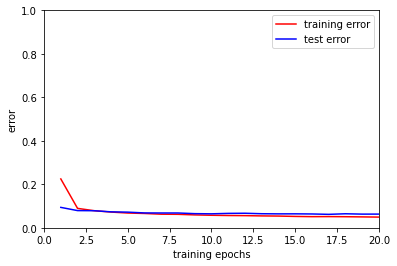

In [7]:
# Network training loop.
for i in range(EPOCHS): # Train EPOCHS iterations
    np.random.shuffle(index_list) # Randomize order
    correct_training_results = 0
    for j in index_list: # Train on all examples
        j *= BATCH_SIZE
        x = np.ones((785, BATCH_SIZE))
        y = np.zeros((10, BATCH_SIZE))
        for k in range(BATCH_SIZE):
            x[1:, k] = x_train[j + k]
            y[:, k] = y_train[j + k]
        forward_pass(x)
        for k in range(BATCH_SIZE):
            if(output_layer_y[:, k].argmax()
                    == y[:, k].argmax()):
                correct_training_results += 1
        backward_pass(y)
        adjust_weights(x)

    correct_test_results = 0
    for j in range(0, (len(x_test) - BATCH_SIZE),
                   BATCH_SIZE): # Evaluate network
        x = np.ones((785, BATCH_SIZE))
        y = np.zeros((10, BATCH_SIZE))
        for k in range(BATCH_SIZE):
            x[1:, k] = x_test[j + k]
            y[:, k] = y_test[j + k]
        forward_pass(x)
        for k in range(BATCH_SIZE):
            if(output_layer_y[:, k].argmax()
                    == y[:, k].argmax()):
                correct_test_results += 1
    # Show progress
    show_learning(i, correct_training_results/len(x_train),
                  correct_test_results/len(x_test))
plot_learning() # Create plot
